In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving record1.zip to record1.zip
User uploaded file "record1.zip" with length 15873326 bytes


In [2]:
# Importy Pythonowe

import json
import os
import zipfile

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

import seaborn as sns
sns.set_style('whitegrid')

import keras as K
import keras.layers as KL

import IPython.display
from IPython.display import HTML

Using TensorFlow backend.


In [0]:
# Czytanie danych do pamięci
records = []
for archive_f in uploaded.keys():
  with zipfile.ZipFile(archive_f) as archive:
    for fileinfo in archive.filelist:
      filename = fileinfo.filename
      if not filename.endswith('.json') or filename.endswith('meta.json'):
        continue
      with archive.open(filename) as f:
        data = json.load(f)
      basename = os.path.basename(filename)
      dirname = os.path.dirname(filename)
      # ucinamy 'record_' z przodu i '.json' z tylu
      step_number = int(basename[7:-5])
      with archive.open(
          os.path.join(dirname, data['image_array'])) as image_file:
        image = ndimage.imread(image_file) / 255.0
      records.append((step_number, image, data['user_angle'], data['user_throttle']))
records.sort(key=lambda x: x[0])
images = np.array([r[1] for r in records], dtype='float32')
angles = np.array([r[2] for r in records], dtype='float32')[:, None]
throttles = np.array([r[3] for r in records], dtype='float32')[:, None]


In [4]:
print('Images to tablica o wymiarach:', images.shape)
print('Angles to tablica o wymiarach:', angles.shape)
print('Throttles to tablica o wymiarach:', throttles.shape)

# Dane (images, angles) podzielimy na 3 podzbiory:
# - dane uczące (train_images, train_angles), na których będziemy trenować modele
# - dane walidacyjne (valid_images, valid_angles) również użyte do treningu modeli
# - dane testowe (test_images, test_angles) na których ocenimy jak dobrze działa
#   nasz model
train_images, valid_images, test_images = np.split(images, [-1000, -500])
train_angles, valid_angles, test_angles = np.split(angles, [-1000, -500])
(train_throttles, valid_throttles, test_throttles
    ) = np.split(throttles, [-1000, -500])

print('Dane uczące mają %d klatek, walidacyjne %d i testowe %d.' % 
      (train_images.shape[0], valid_images.shape[0], test_images.shape[0]))

Images to tablica o wymiarach: (4499, 120, 160, 3)
Angles to tablica o wymiarach: (4499, 1)
Throttles to tablica o wymiarach: (4499, 1)
Dane uczące mają 3499 klatek, walidacyjne 500 i testowe 500.


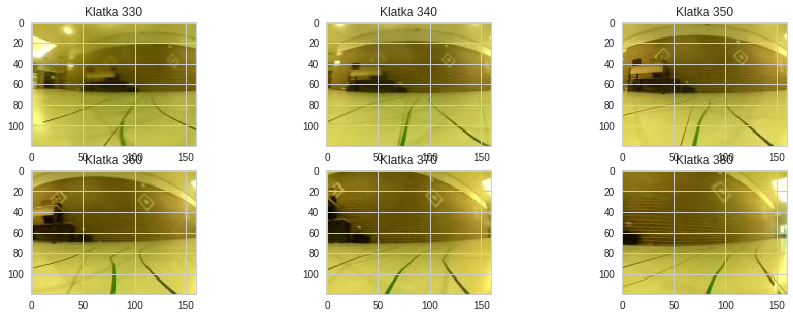

In [5]:
# Wizualizacja danych

plt.figure(figsize=(15, 5))
for i, frame in enumerate(range(330, 390, 10)):
  plt.subplot(2, 3, i + 1)
  plt.imshow(images[frame])
  plt.title("Klatka %d" % (frame,))

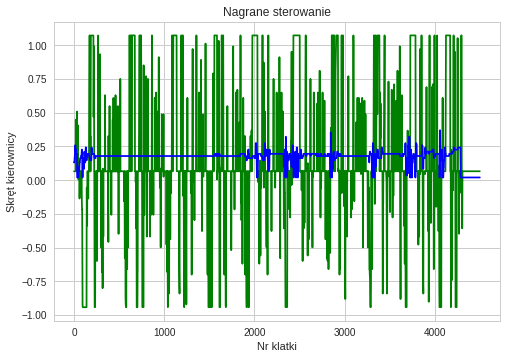

In [6]:
plt.plot(angles, color='g', label='recorded steering')
plt.plot(throttles, color='b', label='recorded steering')
plt.title('Nagrane sterowanie')
plt.xlabel('Nr klatki')
plt.ylabel('Skręt kierownicy')
None

In [0]:
  img_in = KL.Input(shape=(120, 160, 3), name='img_in')
  x = img_in

  # Convolution2D class name is an alias for Conv2D
  x = KL.Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

  x = KL.Flatten(name='flattened')(x)
  x = KL.Dense(units=100, activation='linear')(x)
  x = KL.Dropout(rate=.1)(x)
  x = KL.Dense(units=50, activation='linear')(x)
  x = KL.Dropout(rate=.1)(x)
  # categorical output of the angle
  angle_out = KL.Dense(units=1, activation='linear', name='angle_out')(x)

  # continous output of throttle
  throttle_out = KL.Dense(units=1, activation='linear', name='throttle_out')(x)

  model = K.Model(inputs=[img_in], outputs=[angle_out, throttle_out])

  model.compile(optimizer='adam',
                loss={'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'},
                loss_weights={'angle_out': 0.5, 'throttle_out': 0.5})


In [8]:
callbacks = [
    K.callbacks.ModelCheckpoint('model', save_best_only=True),
    K.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=.0005,
                              patience=5,
                              verbose=True,
                              mode='auto')
]

# Model uczymy na danych uczących.
# Po każdej epoce (ang. epoch) policzymy błąd na danych walidacyjnych i jeśli
# model jest lepszy (błąd jest mniejszy), zapisujemy go.

hist = model.fit(train_images, [train_angles, train_throttles], 
                 epochs=200, 
                 validation_data=(valid_images, [valid_angles, valid_throttles]), 
                 callbacks=callbacks)


Train on 3499 samples, validate on 500 samples
Epoch 1/200
3499/3499 [==============================] - 5s 1ms/step - loss: 0.0866 - angle_out_loss: 0.1695 - throttle_out_loss: 0.0038 - val_loss: 0.0707 - val_angle_out_loss: 0.1369 - val_throttle_out_loss: 0.0046
Epoch 2/200
3499/3499 [==============================] - 3s 848us/step - loss: 0.0532 - angle_out_loss: 0.1042 - throttle_out_loss: 0.0023 - val_loss: 0.0469 - val_angle_out_loss: 0.0910 - val_throttle_out_loss: 0.0028
Epoch 3/200
3499/3499 [==============================] - 3s 847us/step - loss: 0.0450 - angle_out_loss: 0.0880 - throttle_out_loss: 0.0019 - val_loss: 0.0455 - val_angle_out_loss: 0.0889 - val_throttle_out_loss: 0.0022
Epoch 4/200
3499/3499 [==============================] - 3s 830us/step - loss: 0.0434 - angle_out_loss: 0.0852 - throttle_out_loss: 0.0016 - val_loss: 0.0404 - val_angle_out_loss: 0.0784 - val_throttle_out_loss: 0.0025
Epoch 5/200
3499/3499 [==============================] - 3s 819us/step - loss: 

## Analiza wyuczonej sieci
Najpierw sprawdzimy błąd MSE osiągnięty przez sieć.

In [10]:
#@title Wczytywanie najlepszej sieci
best_model = K.models.load_model('model')

print('Obliczony przez Keras błąd walidacyjny:',
      best_model.evaluate(valid_images,
                          [valid_angles, valid_throttles], verbose=0))
print('Obliczony przez Keras błąd testowy:',
      best_model.evaluate(test_images,
                          [test_angles, test_throttles], verbose=0))

Obliczony przez Keras błąd walidacyjny: [0.04044837123155594, 0.07837505257129669, 0.0025216901265084743]
Obliczony przez Keras błąd testowy: [0.042510091051459316, 0.07097552021080628, 0.014044660493265837]


Teraz zobaczymy jak można wykorzystać sieć do przewidywania sterowania na danych testowych:

In [0]:
#@title Użycie najlepszej sieci

# Obliczamy kąty przewidziane przez sieć na danych testowych
pred_test_angles, pred_test_throttles = best_model.predict(test_images)

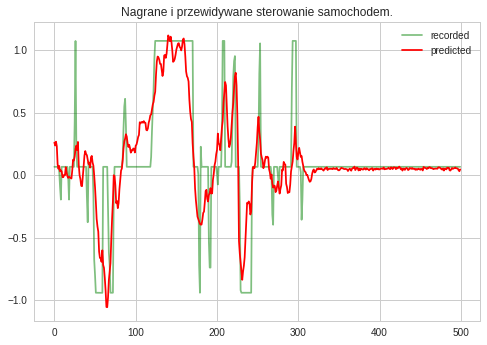

In [12]:
plt.plot(test_angles, label='recorded', color='g', alpha=0.5)
plt.plot(pred_test_angles, label='predicted', color='r')
plt.legend(loc='upper right')
plt.title('Nagrane i przewidywane sterowanie samochodem.')
None

In [0]:
files.download('model')